<a href="https://colab.research.google.com/github/nbadino/ItaOil/blob/main/oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prima bozza del paper di policy evaluation sui prezzi del carburante dopo che i prezzi medi verranno esposti al di fuori di ogni distributore

In [10]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import geopandas as gpd

#shutil.rmtree('/content/ItaOil-main')

# Check if file exists
if not os.path.isfile("/content/main.zip"):
    print("File not found, downloading...")
    # Execute wget command
    try:
        subprocess.check_call(['wget', 'https://github.com/nbadino/ItaOil/archive/refs/heads/main.zip', '-P', '/content'])
        print("File downloaded, unzipping...")
        subprocess.check_call(['unzip', "/content/main.zip", '-d', '/content'])
    except subprocess.CalledProcessError as e:
        print("Could not download or unzip file: ", e)
else:
    print("File exists.")

os.chdir("/content/ItaOil-main")


File exists.


<ipython-input-16-56fec396c37a>:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  location_data = pd.read_csv('/content/ItaOil-main/data/nuovi/anagrafica_impianti_attivi 24-07.csv', sep=';', skiprows=2, names=location_column_names, error_bad_lines=False)
Skipping line 494: expected 10 fields, saw 11
Skipping line 764: expected 10 fields, saw 11
Skipping line 772: expected 10 fields, saw 11
Skipping line 1279: expected 10 fields, saw 11
Skipping line 1526: expected 10 fields, saw 11
Skipping line 2194: expected 10 fields, saw 11
Skipping line 6228: expected 10 fields, saw 11
Skipping line 7577: expected 10 fields, saw 11
Skipping line 8209: expected 10 fields, saw 11
Skipping line 8787: expected 10 fields, saw 11
Skipping line 8788: expected 10 fields, saw 11
Skipping line 8922: expected 10 fields, saw 11
Skipping line 11790: expected 10 fields, saw 11
Skipping line 12179: expected 10 fields, 

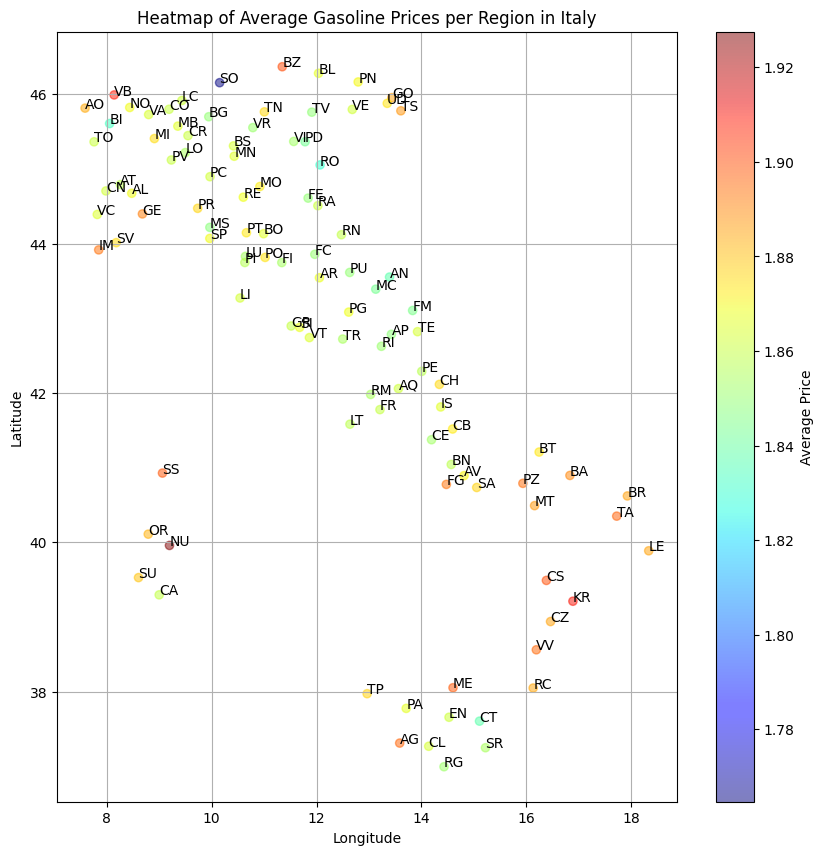

In [16]:
# Define the column names
column_names = ['idImpianto', 'descCarburante', 'prezzo', 'isSelf', 'dtComu']

# Load the price data with the correct column names and separator
data = pd.read_csv('/content/ItaOil-main/data/nuovi/prezzo_alle_8 24-07.csv', sep=';', skiprows=1, names=column_names)

# Filter for 'Benzina' and 'isSelf'='1'
data = data[(data['descCarburante'] == 'Benzina') & (data['isSelf'] == '1')]

# Define the column names for the location data
location_column_names = ['idImpianto', 'Gestore', 'Bandiera', 'Tipo Impianto', 'Nome Impianto', 'Indirizzo', 'Comune', 'Provincia', 'Latitudine', 'Longitudine']

# Load the location data again with the correct column names

location_data = pd.read_csv('/content/ItaOil-main/data/nuovi/anagrafica_impianti_attivi 24-07.csv', sep=';', skiprows=2, names=location_column_names, error_bad_lines=False)

# Ensure 'idImpianto' is of the same type in both datasets
data['idImpianto'] = data['idImpianto'].astype(str)
location_data['idImpianto'] = location_data['idImpianto'].astype(str)

# Merge the two datasets
merged_data = pd.merge(data, location_data, on='idImpianto', how='inner')

# Convert 'Latitudine', 'Longitudine', and 'prezzo' to numeric types
merged_data['Latitudine'] = pd.to_numeric(merged_data['Latitudine'], errors='coerce')
merged_data['Longitudine'] = pd.to_numeric(merged_data['Longitudine'], errors='coerce')
merged_data['prezzo'] = pd.to_numeric(merged_data['prezzo'], errors='coerce')

# Group by 'Provincia' and calculate the mean price
region_data = merged_data.groupby('Provincia')['prezzo'].mean().reset_index()

# Merge with location data to get coordinates for each region
region_location_data = location_data.drop_duplicates('Provincia')
region_merged = pd.merge(region_data, region_location_data, on='Provincia', how='inner')

# Convert 'Latitudine' and 'Longitudine' to numeric types
region_merged['Latitudine'] = pd.to_numeric(region_merged['Latitudine'], errors='coerce')
region_merged['Longitudine'] = pd.to_numeric(region_merged['Longitudine'], errors='coerce')

# Create a scatter plot
plt.figure(figsize=(10,10))
plt.scatter(region_merged['Longitudine'], region_merged['Latitudine'], c=region_merged['prezzo'], cmap='jet', alpha=0.5)
for i, txt in enumerate(region_merged['Provincia']):
    plt.annotate(txt, (region_merged['Longitudine'].iat[i], region_merged['Latitudine'].iat[i]))
plt.colorbar(label='Average Price')
plt.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Average Gasoline Prices per Region in Italy')
plt.show()


In [14]:
province_df = pd.read_csv('/content/ItaOil-main/data/province-sigle.csv', header=None, encoding='latin-1')

# Convert the DataFrame to a dictionary
province_mapping = province_df.set_index(0)[1].to_dict()
italy = gpd.read_file("/content/ItaOil-main/data/gadm41_ITA_2.json.zip")


In [15]:
italy['NAME_2'] = italy['NAME_2'].map(province_mapping)
print(italy['NAME_2'])

0      CH
1      AQ
2      PE
3      TE
4      BA
       ..
105    RO
106    TV
107    VE
108    VR
109    VI
Name: NAME_2, Length: 110, dtype: object


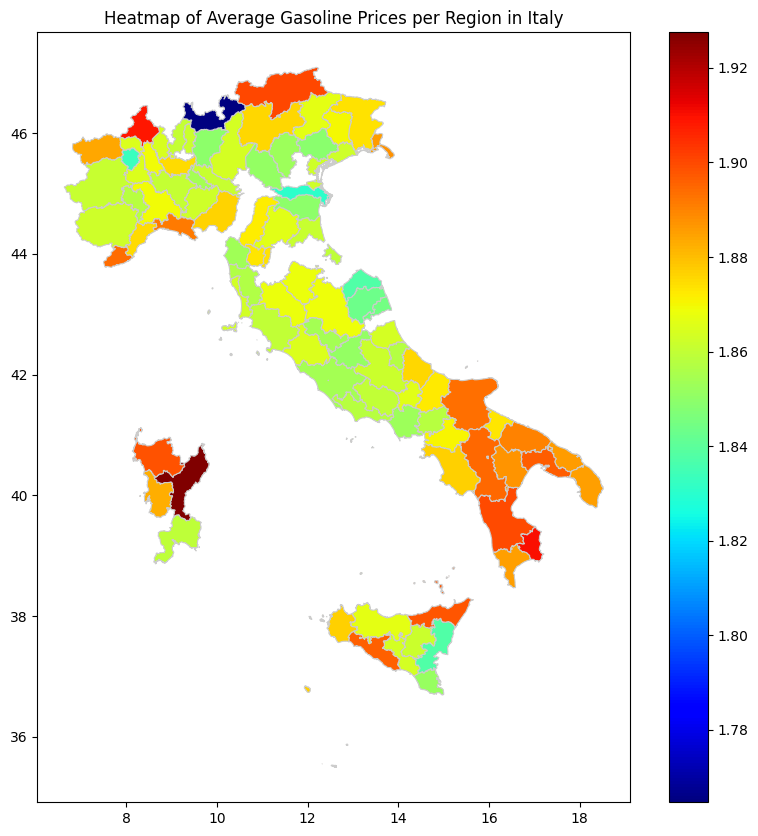

In [19]:
region_merged['Provincia'] = region_merged['Provincia'].str.upper()
italy['NAME_2'] = italy['NAME_2'].str.upper()

# Merge the GeoDataFrame with the average price DataFrame
merged = italy.set_index('NAME_2').join(region_merged.set_index('Provincia'))

# Plot the GeoDataFrame with a color map based on the 'prezzo' column
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column='prezzo', cmap='jet', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Heatmap of Average Gasoline Prices per Region in Italy')
plt.show()